# Decision Tree Classifier from Scratch
Implementation of a decision tree classifier for loan approval prediction

## 1. Data Loading & Preprocessing
Loading loan approval dataset and initial exploration

In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from graphviz import Digraph
from sklearn.metrics import accuracy_score

loan_df = pd.read_csv('loan.csv')
loan_df

,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,32,Male,Engineer,Bachelor's,Married,85000,720,Approved
1,45,Female,Teacher,Master's,Single,62000,680,Approved
2,28,Male,Student,High School,Single,25000,590,Denied
3,51,Female,Manager,Bachelor's,Married,105000,780,Approved
4,36,Male,Accountant,Bachelor's,Married,75000,710,Approved
...,...,...,...,...,...,...,...,...
56,39,Male,Architect,Master's,Married,100000,770,Approved
57,25,Female,Receptionist,High School,Single,32000,570,Denied
58,43,Male,Banker,Bachelor's,Married,95000,760,Approved
59,30,Female,Writer,Master's,Single,55000,650,Approved


### Dataset Overview
The dataset contains:
- **Features**:
  - Demographic information (age, gender, marital status)
  - Financial information (income, credit score)
  - Education level and occupation
- **Target**: Loan status (Approved/Denied)

**Initial Preprocessing**:
- Mapping categorical variables to numerical values
- Dropping high-cardinality features (occupation)

## 2. Core Algorithm Components

### 2.1 Entropy Calculation
Measures impurity using Shannon entropy:
$$ H(S) = -\sum_{i=1}^c p_i \log_2 p_i $$
Where $p_i$ is the proportion of class $i$ in set $S$

In [25]:
def entropy(p): #p is the fraction of the output class out of all the classes
    if p==0 or p==1:
        return 0
    else:
        return -p*np.log2(p)-(1-p)*np.log2(1-p)

### 2.2 Information Gain
Calculates reduction in entropy after split:
$$ IG(S,A) = H(S) - \sum_{t\in T} \frac{|S_t|}{|S|} H(S_t) $$
Where:
- $H(S)$ = entropy of parent node
- $S_t$ = subset of data for split $t$

In [26]:
def information_gain(X, y, indices, feature):
    left_indices, right_indices = splitting(X, indices, feature)

    X_node, y_node = X.iloc[indices], y.iloc[indices]  # FIXED indexing
    X_left, y_left = X.iloc[left_indices], y.iloc[left_indices]
    X_right, y_right = X.iloc[right_indices], y.iloc[right_indices]

    w_left = len(X_left) / (len(indices) + 1e-9)  
    w_right = len(X_right) / (len(indices) + 1e-9)  

    # Prevent division by zero
    p_left = sum(y_left[y_left == 1]) / (len(y_left) + 1e-9)
    p_right = sum(y_right[y_right == 1]) / (len(y_right) + 1e-9)
    p_root = sum(y_node[y_node == 1]) / (len(y_node) + 1e-9)

    h_root = entropy(p_root)

    return h_root - (w_left * entropy(p_left) + w_right * entropy(p_right))

In [27]:
def get_best_split(X,y,indices):

    num_features = X.shape[1]
    max_info_gain = 0
    best_feature=None

    for feature in range(num_features):
        info_gain = information_gain(X,y,indices,feature)
        if max_info_gain<info_gain:
            max_info_gain =info_gain
            best_feature=feature

    return best_feature

### 2.3 Splitting Criteria
Custom splitting logic for different feature types:
- **Numerical**: Threshold-based splits (age > 29)
- **Categorical**: Group-based splits (education levels)
- **Binary**: Direct value splits

In [28]:
def splitting(X, indices, feature):
    left_indices = []
    right_indices = []

    if feature == 0:  # age
        for i in indices:
            if X.iloc[i, feature] > 29:
                left_indices.append(i)
            else:
                right_indices.append(i)

    elif feature == 2:  # education_level
        for i in indices:
            if X.iloc[i, feature] in ["Bachelor's", "Master's", "Doctoral"]:
                left_indices.append(i)
            else:
                right_indices.append(i)

    elif feature == 4:  # income
        for i in indices:
            if X.iloc[i, feature] > 52000:
                left_indices.append(i)
            else:
                right_indices.append(i)

    elif feature == 5:  # credit_score
        for i in indices:
            if X.iloc[i, feature] > 660:
                left_indices.append(i)
            else:
                right_indices.append(i)

    else:  # for binary variables
        for i in indices:
            if X.iloc[i, feature] == 1:
                left_indices.append(i)
            else:
                right_indices.append(i)

    return left_indices, right_indices


## 3. Data Exploration & Feature Engineering

### Feature-Target Relationships
Visualizing relationships between key features and loan status

In [29]:
y = loan_df['loan_status'].map({'Approved': 1, 'Denied': 0})
X = loan_df.drop('loan_status',axis=1)

X['gender'] = loan_df['gender'].map({'Male': 1, 'Female': 0})
X['marital_status'] = loan_df['marital_status'].map({'Married': 1, 'Single': 0})

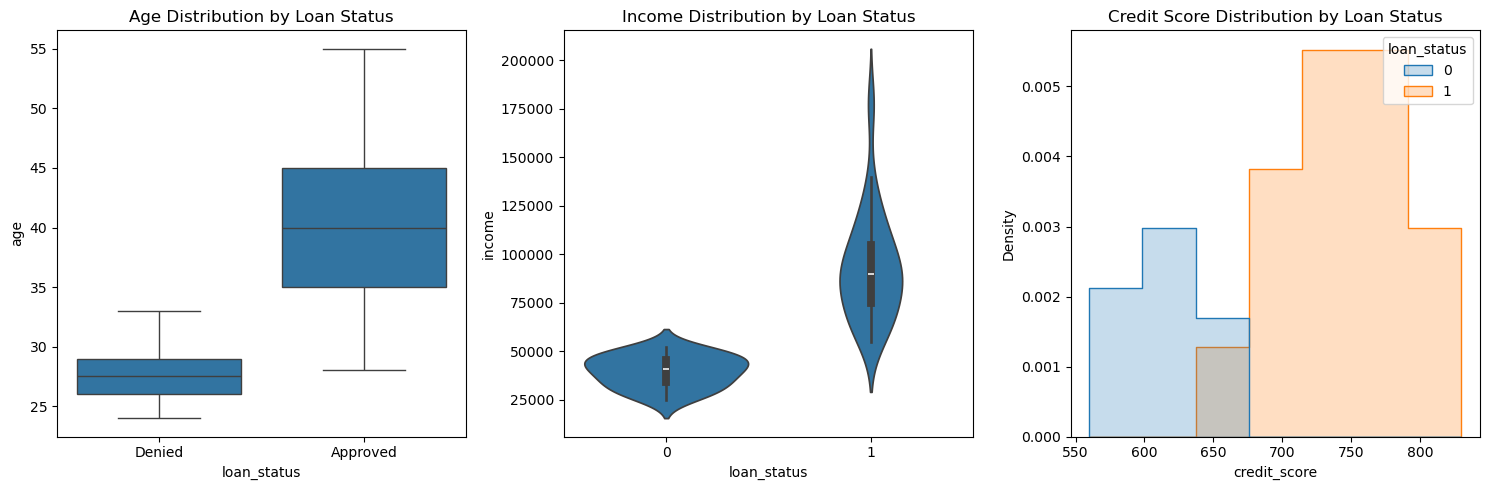

In [30]:
# Enhanced feature visualization
plt.figure(figsize=(15, 5))

# Age vs Loan Status
plt.subplot(1, 3, 1)
sns.boxplot(x=y, y=X['age'])
plt.title('Age Distribution by Loan Status')
plt.xticks([0, 1], ['Denied', 'Approved'])

# Income vs Loan Status
plt.subplot(1, 3, 2)
sns.violinplot(x=y, y=X['income'])
plt.title('Income Distribution by Loan Status')

# Credit Score vs Loan Status
plt.subplot(1, 3, 3)
sns.histplot(data=X, x='credit_score', hue=y, element='step', stat='density')
plt.title('Credit Score Distribution by Loan Status')

plt.tight_layout()
plt.show()

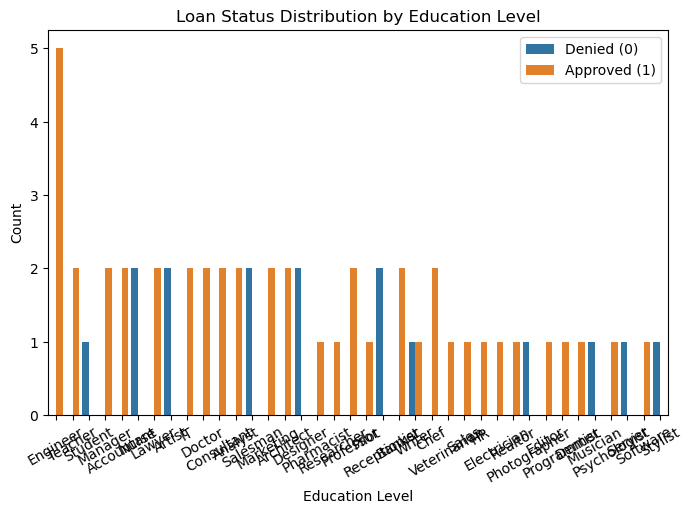

In [31]:
plt.figure(figsize=(8, 5))
sns.countplot(data=loan_df, x="occupation", hue=y)
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.title("Loan Status Distribution by Education Level")
plt.legend(["Denied (0)", "Approved (1)"])
plt.xticks(rotation=30)  # Rotate if labels are long
plt.show()

In [32]:
X = X.drop('occupation',axis =1 )

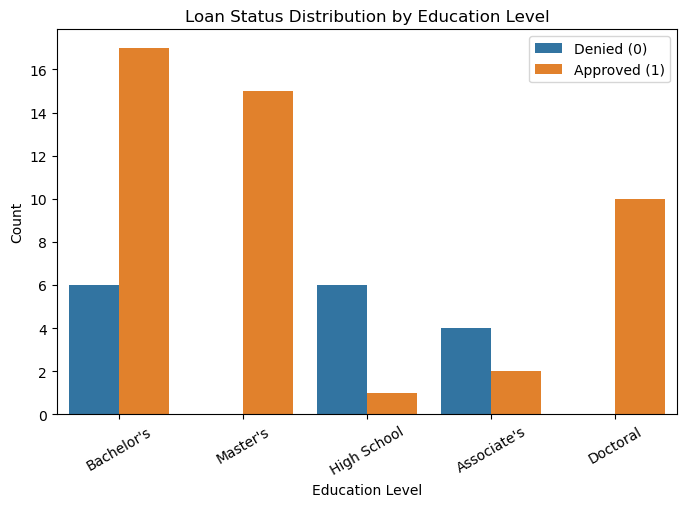

In [33]:

plt.figure(figsize=(8, 5))
sns.countplot(data=loan_df, x="education_level", hue=y)
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.title("Loan Status Distribution by Education Level")
plt.legend(["Denied (0)", "Approved (1)"])
plt.xticks(rotation=30)  # Rotate if labels are long
plt.show()

## 4. Tree Construction & Training

### Tree Building Process
Recursive tree construction with depth control:
- Maximum depth stopping criterion
- Leaf node creation when pure node reached

In [59]:
def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth, tree):
    if current_depth == max_depth or len(set(y.iloc[node_indices])) == 1:
        tree.append((node_indices, "leaf"))  # Store leaf first
        return tree  # Return modified tree

    best_feature = get_best_split(X, y, node_indices)
    left_indices, right_indices = splitting(X, node_indices, best_feature)
    
    # Store current split node BEFORE children
    tree.append((left_indices, right_indices, best_feature))
    
    # Build left/right subtrees and extend the main tree
    tree = build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1, tree)
    tree = build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1, tree)
    
    return tree

In [60]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 45, shuffle=True)

In [63]:
initial_indices = np.arange(len(X_train))
tree = []
tree = build_tree_recursive(X_train, y_train, initial_indices, "Root" , max_depth=3, current_depth=0, tree=tree)

## 5. Model Evaluation & Visualization

In [64]:
def predict_sample(sample, tree, y_train):
    current_index = 0  # Start at root node
    
    while True:
        node = tree[current_index]
        
        # Leaf node - return majority class
        if len(node) == 2:
            indices, _ = node
            class_counts = y_train.iloc[indices].value_counts()
            return 1 if class_counts.get(1, 0) > class_counts.get(0, 0) else 0
        
        # Split node - navigate left or right
        left_indices, right_indices, feature = node
        
        # Get split condition check
        if feature == 0:  # Age
            go_left = sample['age'] > 29
        elif feature == 2:  # Education
            go_left = sample['education_level'] in ["Bachelor's", "Master's", "Doctoral"]
        elif feature == 4:  # Income
            go_left = sample['income'] > 52000
        elif feature == 5:  # Credit Score
            go_left = sample['credit_score'] > 660
        else:  # Binary features
            go_left = sample.iloc[feature] == 1
        
        # Move to next node based on split
        if go_left:
            current_index += 1  # Left child is next node
        else:
            # Find the start of right subtree by skipping left subtree
            left_subtree_size = count_subtree_nodes(tree, current_index + 1)
            current_index += left_subtree_size + 1


# Usage
y_pred = predict(X_test, tree, y_train)

In [65]:
accuracy_score(y_test,y_pred)

1.0

### Class Distribution Analysis
Comparing class balance in training and test sets

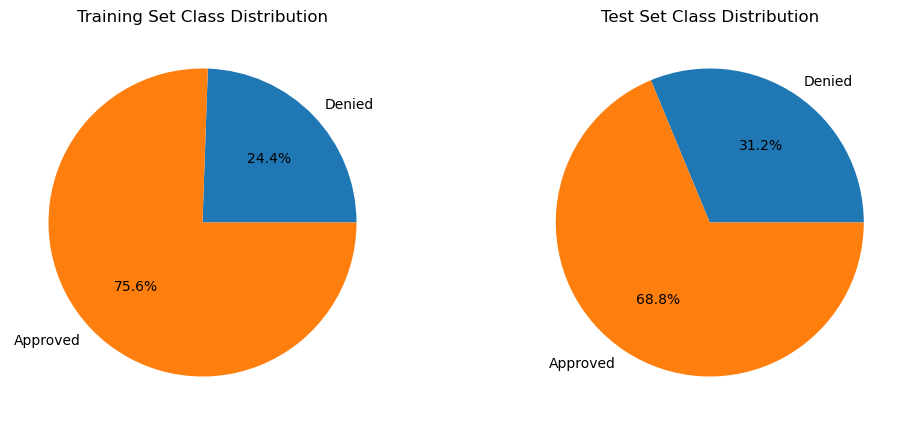

In [66]:
# Class distribution visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

ax[0].pie(train_counts, labels=['Denied', 'Approved'], autopct='%1.1f%%')
ax[0].set_title('Training Set Class Distribution')

ax[1].pie(test_counts, labels=['Denied', 'Approved'], autopct='%1.1f%%')
ax[1].set_title('Test Set Class Distribution')

plt.show()

### Decision Surface Visualization
2D decision boundaries using key features

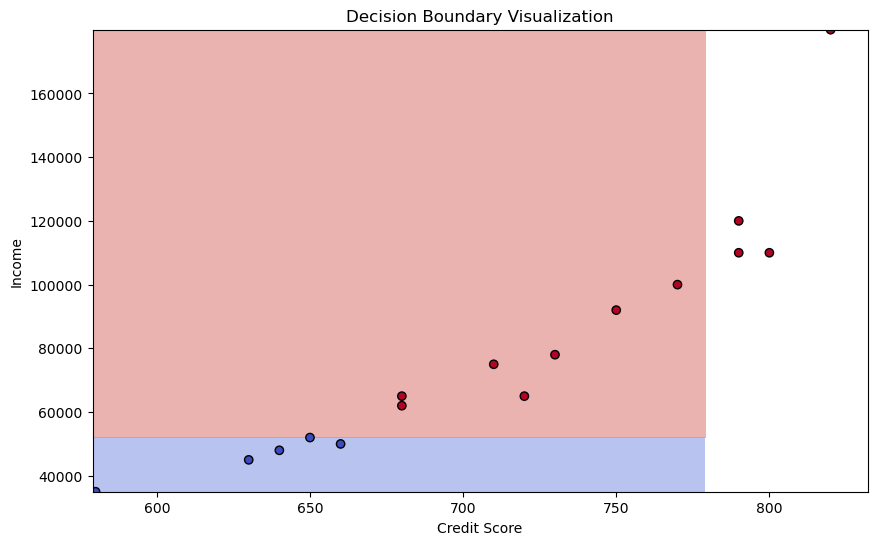

In [67]:
# Decision boundary plot
def plot_decision_boundary(X, y, tree):
    # Select two most important features
    features = ['credit_score', 'income']
    X_plot = X[features]
    
    # Create mesh grid
    x_min, x_max = X_plot.iloc[:, 0].min()-1, X_plot.iloc[:, 0].max()+1
    y_min, y_max = X_plot.iloc[:, 1].min()-1, X_plot.iloc[:, 1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 100),
                         np.arange(y_min, y_max, 100))

    # Predict for grid points
    grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], 
                              columns=features)
    Z = predict(grid_points, tree, y_train)
    Z = Z.values.reshape(xx.shape)

    # Plot decision surface
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    plt.scatter(X_plot.iloc[:, 0], X_plot.iloc[:, 1], c=y, 
                edgecolor='k', cmap='coolwarm')
    plt.xlabel('Credit Score')
    plt.ylabel('Income')
    plt.title('Decision Boundary Visualization')
    plt.show()

plot_decision_boundary(X_test, y_test, tree)

### Feature Importance Analysis
Visualizing feature importance based on split frequency

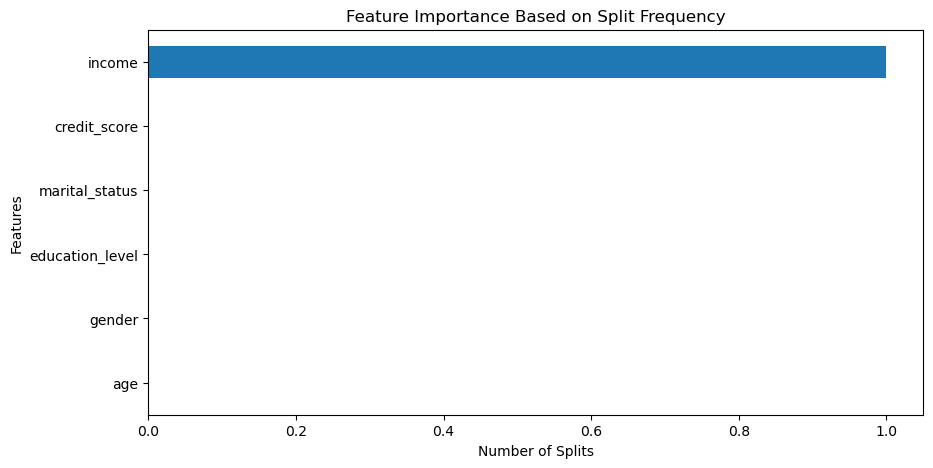

In [68]:
# Feature importance visualization
def get_feature_importance(tree):
    importance = {feature: 0 for feature in X.columns}
    for node in tree:
        if len(node) == 3:
            importance[X.columns[node[2]]] += 1
    
    plt.figure(figsize=(10, 5))
    pd.Series(importance).sort_values().plot(kind='barh')
    plt.title('Feature Importance Based on Split Frequency')
    plt.xlabel('Number of Splits')
    plt.ylabel('Features')
    plt.show()

get_feature_importance(tree)